#### Time Series Anomaly Exercises

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

Hint: You will need to explore the database and significantly adjust your acquisition step (yay SQL!)

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import env
import os

In [2]:
# let's pull the dataset from the sql server
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
query = '''
SELECT *
FROM logs
LEFT JOIN cohorts on cohorts.id = logs.cohort_id;
'''

if os.path.isfile('curriculum_logs.csv'):
    df = pd.read_csv('curriculum_logs.csv', index_col = 0)
    
else:
    df = pd.read_sql(query, url)
    
    df.to_csv('curriculum_logs.csv')
    
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900223 entries, 0 to 900222
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          900223 non-null  object 
 6   id          847330 non-null  float64
 7   name        847330 non-null  object 
 8   slack       847330 non-null  object 
 9   start_date  847330 non-null  object 
 10  end_date    847330 non-null  object 
 11  created_at  847330 non-null  object 
 12  updated_at  847330 non-null  object 
 13  deleted_at  0 non-null       float64
 14  program_id  847330 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 109.9+ MB


In [4]:
# let's drop the nulls
df.isna().sum()

date               0
time               0
path               1
user_id            0
cohort_id      52893
ip                 0
id             52893
name           52893
slack          52893
start_date     52893
end_date       52893
created_at     52893
updated_at     52893
deleted_at    900223
program_id     52893
dtype: int64

In [5]:
# concatenate and change date type columns to the respective type 
df['date_time'] = df.date + ' ' + df.time
df.date_time = pd.to_datetime(df.date_time, format = '%Y-%m-%d %H:%M:%S')
df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)
df.created_at = pd.to_datetime(df.created_at)
df.deleted_at = pd.to_datetime(df.deleted_at)

# missing entirety of columns
df.drop(['id', 'slack','deleted_at', 'date', 'time'], inplace = True, axis = 1)

# let's clean up the dataset
df.dropna(inplace = True)

# set the index
df = df.set_index(df.date_time)

# let's rename some columns
df.rename(columns = {'path':'endpoint', 'ip':'source_ip'}, inplace = True)

# add program name to dataframe
df['program_name'] = df.program_id.map({1.0: 'Full-Stack PHP',
                                        2.0: 'Full-Stack Java',
                                        3.0: 'Data Science',
                                        4.0: 'Front-End'})

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 847329 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   endpoint      847329 non-null  object        
 1   user_id       847329 non-null  int64         
 2   cohort_id     847329 non-null  float64       
 3   source_ip     847329 non-null  object        
 4   name          847329 non-null  object        
 5   start_date    847329 non-null  datetime64[ns]
 6   end_date      847329 non-null  datetime64[ns]
 7   created_at    847329 non-null  datetime64[ns]
 8   updated_at    847329 non-null  object        
 9   program_id    847329 non-null  float64       
 10  date_time     847329 non-null  datetime64[ns]
 11  program_name  847329 non-null  object        
dtypes: datetime64[ns](4), float64(2), int64(1), object(5)
memory usage: 84.0+ MB


1. Label students by the program they are in.

In [6]:
df.name.unique()

array(['Hampton', 'Teddy', 'Sequoia', 'Arches', 'Niagara', 'Pinnacles',
       'Quincy', 'Kings', 'Lassen', 'Mammoth', 'Glacier', 'Denali',
       'Joshua', 'Olympic', 'Ulysses', 'Badlands', 'Apollo', 'Ike',
       'Voyageurs', 'Wrangell', 'Xanadu', 'Franklin', 'Yosemite', 'Staff',
       'Zion', 'Andromeda', 'Betelgeuse', 'Ceres', 'Bayes', 'Deimos',
       'Europa', 'Fortuna', 'Curie', 'Apex', 'Ganymede', 'Everglades',
       'Hyperion', 'Darden', 'Bash', 'Jupiter', 'Kalypso', 'Luna',
       'Easley', 'Marco', 'Neptune', 'Florence', 'Oberon'], dtype=object)

In [7]:
df[['user_id','name', 'program_name']].value_counts()

user_id  name     program_name   
11       Staff    Full-Stack Java    15178
64       Staff    Full-Stack Java    12530
53       Lassen   Full-Stack PHP      8197
495      Deimos   Full-Stack Java     6451
428      Staff    Full-Stack Java     5819
                                     ...  
212      Arches   Full-Stack PHP         1
879      Marco    Full-Stack Java        1
952      Olympic  Full-Stack PHP         1
163      Quincy   Full-Stack PHP         1
165      Niagara  Full-Stack Java        1
Length: 952, dtype: int64

2. Is it possible to identify the user_id of a staff member?

In [8]:
df[df['name'] == 'Staff'].user_id.unique()

array([ 53, 314,  40,  64,  11, 211,   1, 312, 146, 248, 370, 397, 404,
       257, 428, 461,  37, 514, 539, 545, 546, 572, 315,  41, 592, 618,
       620, 521, 652, 502, 653, 480, 738, 742, 745, 813, 430, 816, 581,
       854, 855, 744, 893, 148, 894, 513, 630, 308, 951, 953, 980])

3. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.

In [20]:
no_staff = df[df['name'] != 'Staff']
no_staff[no_staff['date_time'] > no_staff['end_date']].user_id.unique()

array([  1,  11,  21,  26,  37,  40,  50,  51,  53,  60,  64,  66,  67,
        68,  69,  70,  71,  72,  75,  76,  77,  80,  81,  82,  83,  84,
        85,  87,  90,  91,  92,  93,  94,  95,  96,  97,  98,  42, 101,
        47, 102,  16,  41,  17,  22,  15, 104,  57,  10, 105, 106,  28,
       107,  65,  52,  33,  56, 108,  27,  38,  36, 109, 110, 112, 113,
       114, 115, 139, 140, 141, 143, 144, 146, 147, 148, 149, 150, 151,
       152, 153, 156, 161, 162, 163, 164, 165, 167, 168, 169, 170, 172,
       173, 174, 175, 177, 178, 179,  18,   6,  29,  19, 180,  99,  43,
        31,   7, 181, 138,  35, 142,   5, 155, 154,  88, 209, 210,   3,
        20, 118, 211, 212, 214, 216, 217, 130, 135, 131, 128, 127, 124,
       159,  12, 145, 241, 242, 136, 157, 171, 123,  25, 134, 119, 243,
       244, 245, 246, 160, 248, 252, 254, 255, 120, 257, 279, 280, 281,
        14, 188, 215, 253, 186, 283, 184, 278, 183, 204, 193, 195, 197,
       249, 206, 284, 121, 201, 285, 286, 311, 190, 312, 116, 20

4. Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2.

In [25]:
pages = df['endpoint'].resample('d').count()
pages.head()

# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
# 14 days EMA
ema_14d = pages.ewm(span=14).mean()
# 30 days EMA
ema_30d = pages.ewm(span=30).mean()
# 90 days EMA
ema_90d = pages.ewm(span=90).mean()

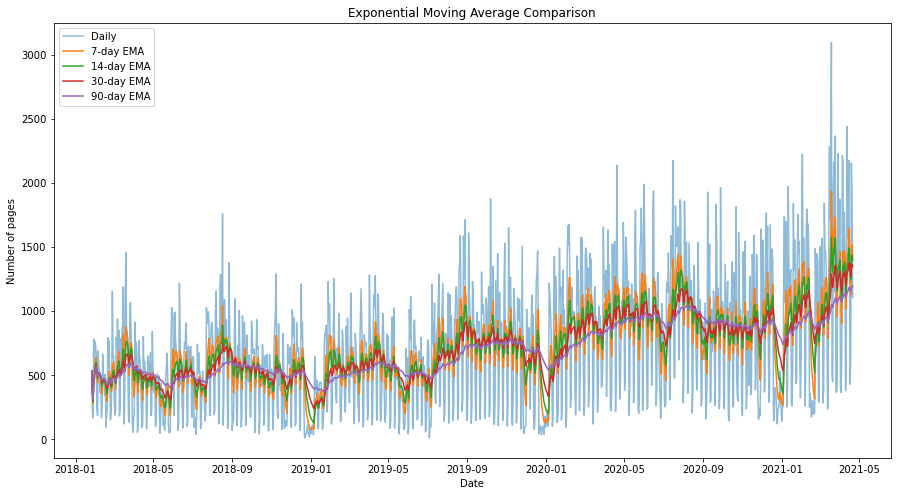

In [29]:
fig, ax = plt.subplots(figsize = (15,8))

ax.plot(pages.index, pages, label = 'Daily', alpha = .5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc = 'best')
ax.set_ylabel('Number of pages')
ax.set_xlabel('Date')
plt.title('Exponential Moving Average Comparison')

plt.show();

In [31]:
# bandwidths

# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date_time
2018-01-26    533.000000
2018-01-27    376.450000
2018-01-28    302.284709
2018-01-29    434.739290
2018-01-30    475.525441
Freq: D, Name: endpoint, dtype: float64

In [32]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()

date_time
2018-01-26           NaN
2018-01-27    214.253355
2018-01-28    192.738756
2018-01-29    292.489456
2018-01-30    262.780177
Freq: D, Name: endpoint, dtype: float64

In [34]:
# compute upper and lower bands with k @ 2
ub = midband + stdev * 2
lb = midband - stdev * 2

# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date_time,,
2018-01-26,NaN,NaN
2018-01-27,804.956709,-52.056709
2018-01-28,687.762221,-83.192803
2018-01-29,1019.718202,-150.239623
2018-01-30,1001.085795,-50.034912


In [35]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date_time,,,,
2018-01-26,533,533.000000,NaN,NaN
2018-01-27,230,376.450000,804.956709,-52.056709
2018-01-28,168,302.284709,687.762221,-83.192803
2018-01-29,783,434.739290,1019.718202,-150.239623
2018-01-30,614,475.525441,1001.085795,-50.034912


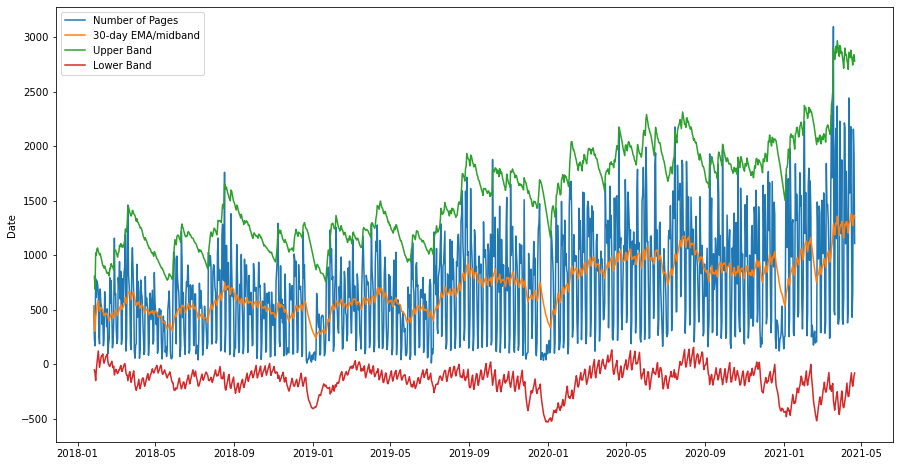

In [36]:
fig, ax = plt.subplots(figsize = (15,8))

ax.plot(my_df.index, my_df.pages, label = 'Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')
ax.set_ylabel('Date')

plt.show();

5. Plot the access activity of these students.

BONUS: Identify users who are viewing both the web dev and data science curriculum